## Ralph Mouawad - M2 Data Science
## Ecole Polytechnique - Practical Introduction to Machine Learning
## Lab 2 - Supervised Learning - Regression

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# 1-2- Dataset Description, Data Visualization and Pre-Processing

In [3]:
ECoG = np.load('ECoG.npz')

Xall, Yall, Fe = ECoG['Xall'], ECoG['Yall'], ECoG['Fe']

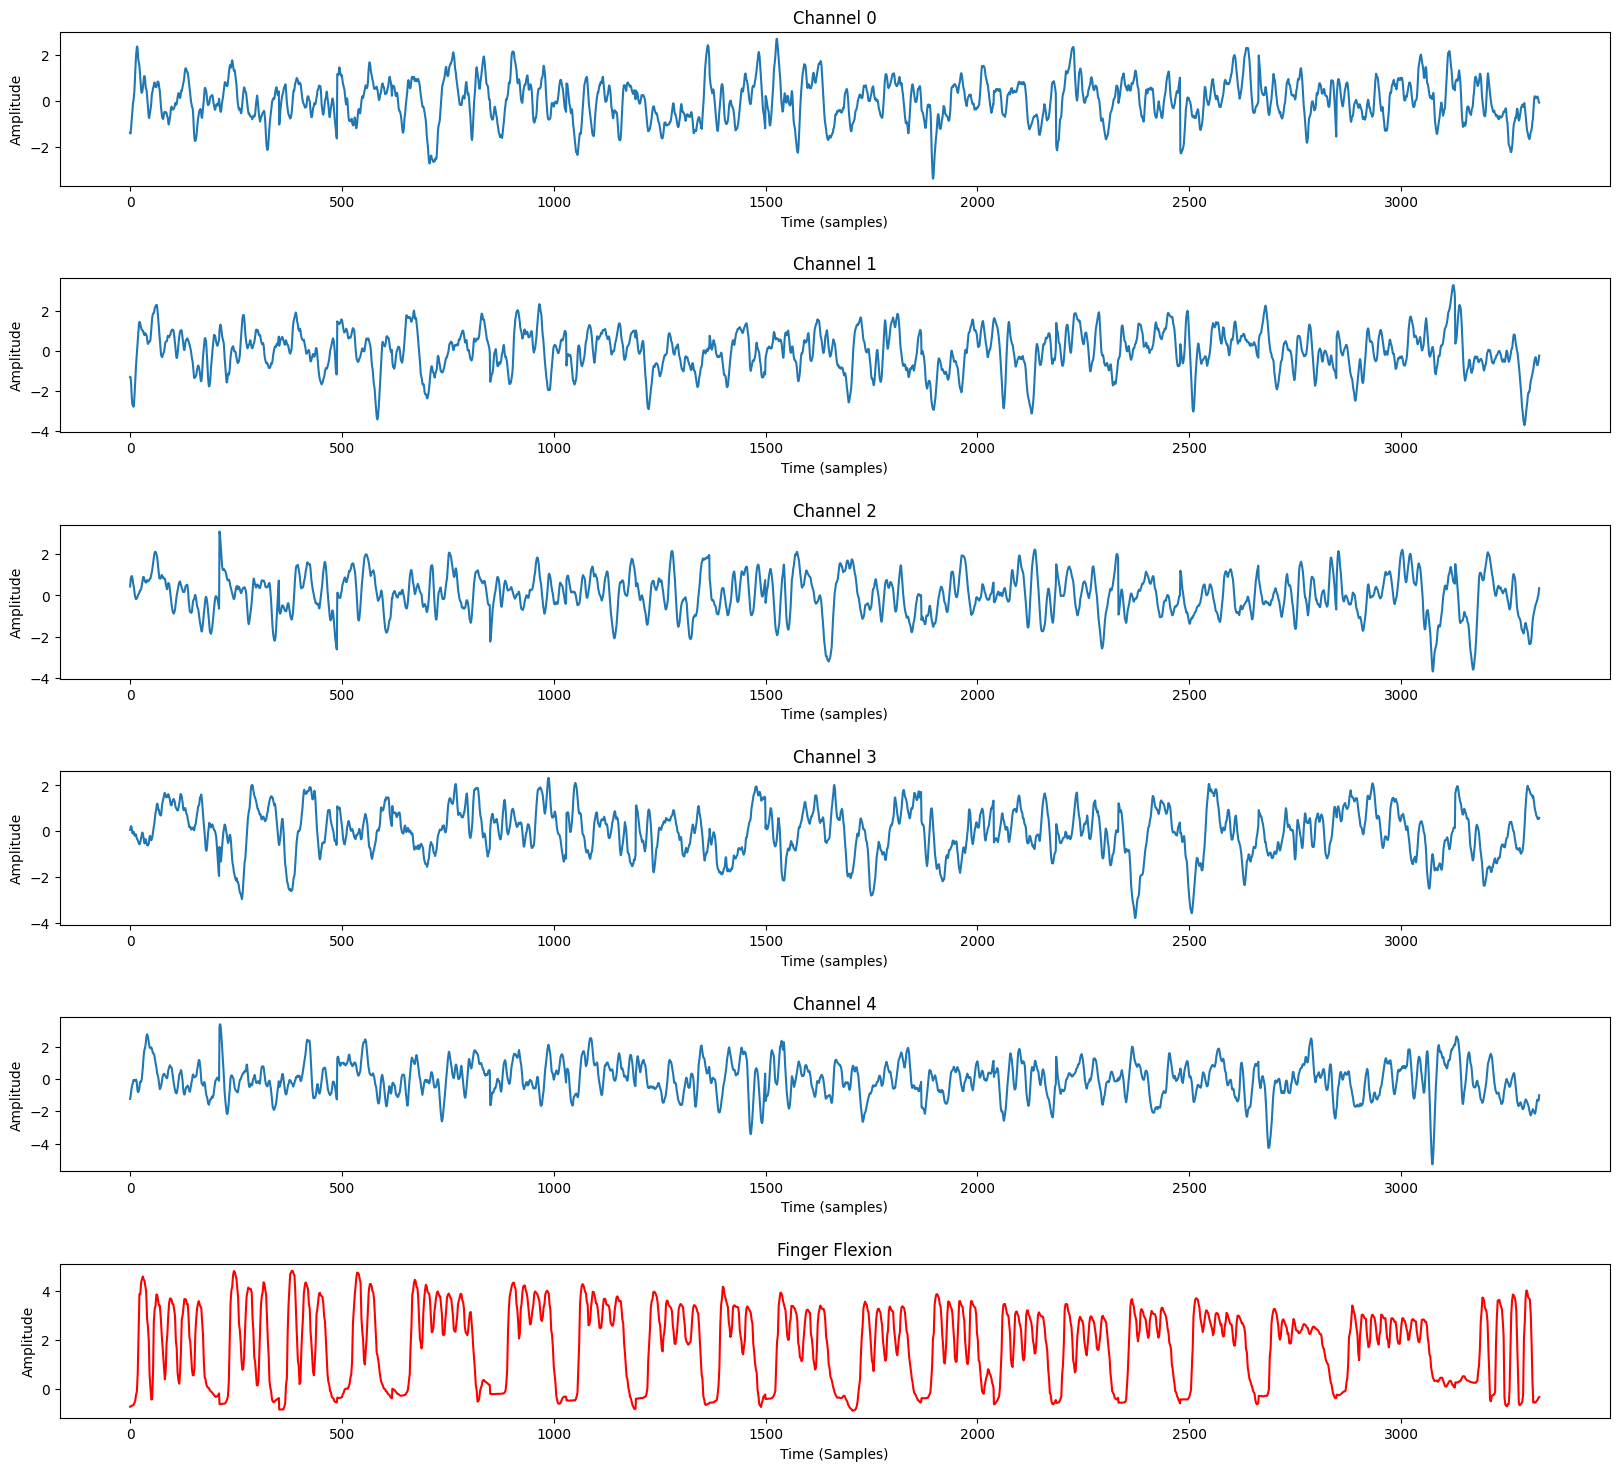

In [4]:
num_plots = 5
plt.figure(figsize=(20, 18))

for i in range(num_plots):
    plt.subplot(num_plots+1, 1, i+1)
    plt.plot(range(Xall.shape[0]), Xall[:, i])
    plt.title(f'Channel {i}')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

# Last subplot for Yall
plt.subplot(num_plots+1, 1, num_plots+1)
plt.plot(range(Yall.shape[0]), Yall, color="red")
plt.title('Finger Flexion')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')

# Adjust spacing
plt.subplots_adjust(hspace=0.6)  # <-- increase this for more space

plt.show()


- We can realize that for the 5 electrode channels we are visualizing, the values are in the interval [-2,2], the signal is noisy but not a lot. It is hard to interpret whether the channels depend on time in this case.
- We can realize that for the finger flexion, we can see a pattern in the function that is repeated every 200 time steps. They should be some temporal dependencies between the finger flexion and time.

- The goal here is to see whether the input of the 64 electrodes at every time step can predict the finger flexion. We will do this using supervised learning models.

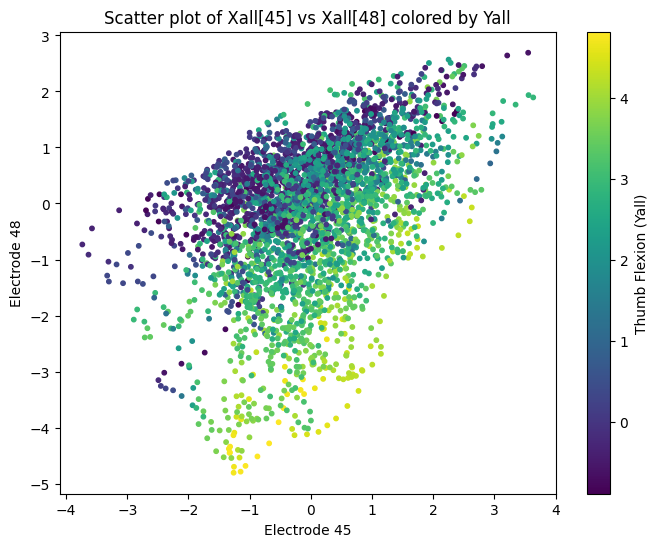

In [5]:
plt.figure(figsize=(8,6))

sc=plt.scatter(Xall[:,45], Xall[:,48], c=Yall, cmap="viridis", s=10)
plt.colorbar(sc, label="Thumb Flexion (Yall)")
plt.xlabel("Electrode 45")
plt.ylabel('Electrode 48')
plt.title("Scatter plot of Xall[45] vs Xall[48] colored by Yall")

plt.show()

We can interpret this as follows:

- We observe a very high value for Yall when we have a small value for electrode 48.
- As electrode 48's value increases, the value for Yall decreases.
- We can see noisy observations: there are overlapping regions between high and low values for Yall.
- There is some positive linear relationship between electrodes 45 and 48.
- I'm afraid of facing the issue of multicollinearity and end up with biased coefficients. That could be solved with regularization.


In [6]:
n=1000
x_train, y_train = Xall[:n, :], Yall[:n, :]
x_test, y_test = Xall[n:,:], Yall[n:, :]

3) Least Squares Regression (LS)

In [10]:
X_training = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
X_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)

In [11]:
## Computing the Weights by solving the linear system

theta = np.linalg.solve(X_training.T @ X_training, X_training.T @ y_train)

w= theta[1:]
b=theta[0]

In [12]:
predict_train_ls = X_training @ theta

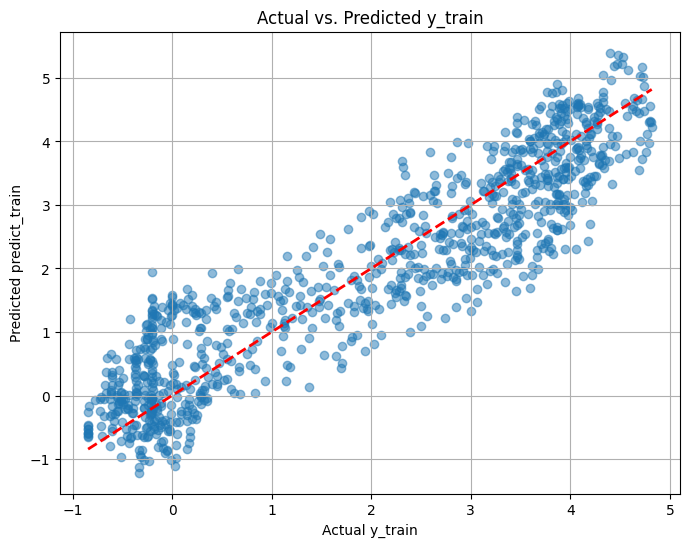

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(y_train, predict_train_ls, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2) # Add a line for perfect prediction
plt.xlabel("Actual y_train")
plt.ylabel("Predicted predict_train")
plt.title("Actual vs. Predicted y_train")
plt.grid(True)
plt.show()


In [14]:
predict_test_ls = X_test @ theta

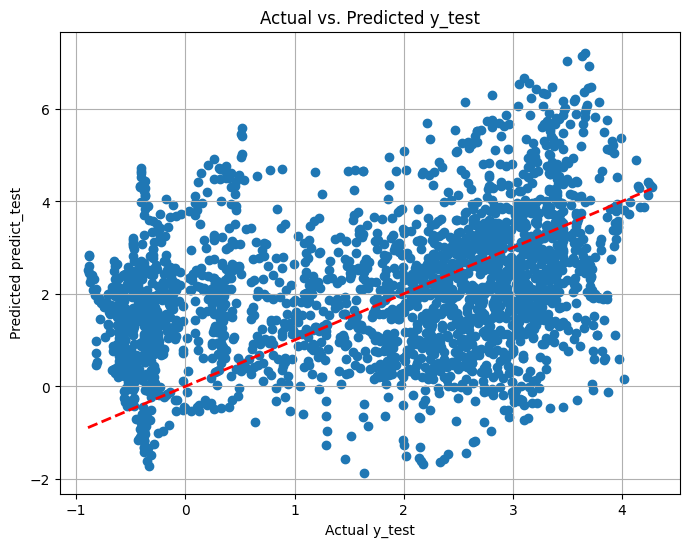

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, predict_test_ls)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a line for perfect prediction
plt.xlabel("Actual y_test")
plt.ylabel("Predicted predict_test")
plt.title("Actual vs. Predicted y_test")
plt.grid(True)
plt.show()

Training Data:
- We can see that the fitting line between predicted and actual values look good. The distance between every point and the line isn't very big, and the error seems similar to all points (low variance). The results look good.

Testing Data:
- We can see that the fitting line between the predicted values and actual values is bad. The points are very far from the line, which indicates that the model didn't perform good predictions. We also notice some bias in the model: when Y is small (close to 0), it is predicting a very high value, so the bias here is higher than when Y is smaller. For example, when Y is around 3, the model predicts around5-6. However, when Y is around 0, the model predicts around 6. We can see also some bias for large values of Y, as the model is predicting a relatively smaller number.

Since the model performed well on the training set but bad on the test set, we can say that we are suffering from overfitting. I will comment on this based on the values of MSE and R2.

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
mse_train_ls= mean_squared_error(y_train, predict_train_ls)
r2_train_ls = r2_score(y_train, predict_train_ls)

print('MSE on the training data:', mse_train_ls)
print('R2 on the training data:', r2_train_ls)

MSE on the training data: 0.5040654614476062
R2 on the training data: 0.8395001217500111


In [18]:
mse_test_ls = mean_squared_error(y_test, predict_test_ls)
r2_test_ls = r2_score(y_test, predict_test_ls)

print('MSE on the test data:', mse_test_ls)
print('R2 on the test data:', r2_test_ls)

MSE on the test data: 3.0455368767601625
R2 on the test data: -0.42817006302225247


As stated before, the model suffers from overfitting:
- On the train set, R2 = 0.839 means that our model is capable of capturing 84% of the total variance of predictions. The MSE isn't very high (0.5).
- On the test, R2 is much lower meaning that our model doesn't capture the total variance. The MSE is also very high (3.04) which indicates that there's a lot of difference in values between our predictions and actual values.

We conclude, as stated above, that we are suffering from overfitting.

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

w_lr = lr.coef_
b_lr = lr.intercept_

In [20]:
print('Intercept with Linear System:', b)
print('Intercept with Linear Regression:', b_lr)

Intercept with Linear System: [1.90081255]
Intercept with Linear Regression: [1.90081255]


In [21]:
print('Difference between the weights:', np.linalg.norm(w-w_lr.T))

Difference between the weights: 3.919826109876624e-14


We can see that our parameters are the same. That is expected because LS is a convex function so inverting it or using gradient descent will lead to the same results.

4) Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

In [23]:
ridge = Ridge(alpha=1)

ridge.fit(x_train, y_train)

Ridge(alpha=1)

In [24]:
prediction_train_ridge = ridge.predict(x_train)
prediction_test_ridge = ridge.predict(x_test)

In [25]:
print('MSE on the training data:', mean_squared_error(y_train, prediction_train_ridge))
print('R2 on the training data:', r2_score(y_train, prediction_train_ridge))

MSE on the training data: 0.5041768297327898
R2 on the training data: 0.8394646608871272


In [26]:
print('MSE on the test data:', mean_squared_error(y_test, prediction_test_ridge))
print('R2 on the test data:', r2_score(y_test, prediction_test_ridge))

MSE on the test data: 3.0038429595355707
R2 on the test data: -0.40861817223916197


The results on training data are still similar, and the results for the test are very slightly better. We are still suffering from overfitting. Perhaps increasing the value of lambda would give us a better generalization.

In [27]:
lambdas = np.logspace(-3, 5, 100)

coefs = []
MSE_train = []
MSE_test = []

for lmbd in lambdas:
    ridge = Ridge(alpha=lmbd)
    ridge.fit(x_train, y_train)

    # Predictions
    prediction_train = ridge.predict(x_train)
    prediction_test = ridge.predict(x_test)

    # MSEs
    MSE_train.append(mean_squared_error(y_train, prediction_train))
    MSE_test.append(mean_squared_error(y_test, prediction_test))

    # Coefficients
    coefs.append(ridge.coef_)

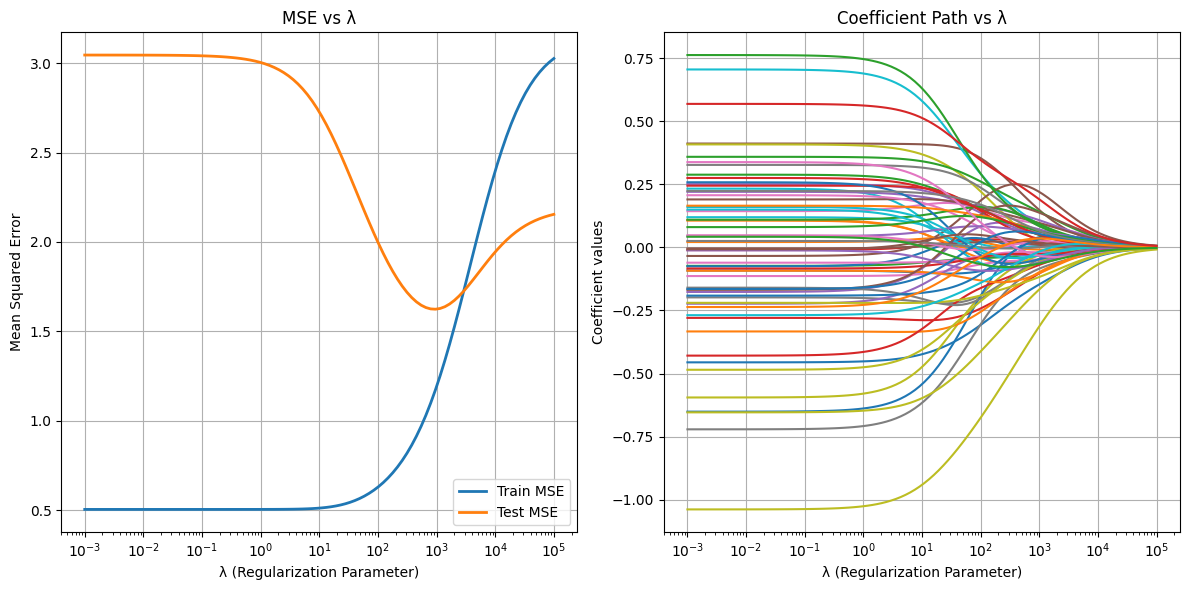

In [28]:
plt.figure(figsize=(12, 6))

# MSE evolution
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, MSE_train, label='Train MSE', linewidth=2)
plt.semilogx(lambdas, MSE_test, label='Test MSE', linewidth=2)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs λ')
plt.legend()
plt.grid(True)

# Coefficient evolution
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, coefs)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Coefficient values')
plt.title('Coefficient Path vs λ')
plt.grid(True)

plt.tight_layout()
plt.show()

1. MSE vs lambda

For small lambda values (10^-3 to 10), the model behaves similarly to ordinary least squares, with almost no regularization and overfitting.

The training MSE is very low, indicating that the model fits the training data closely.

However, the testing MSE is higher, revealing signs of overfitting.

As lambda increases (10 to 10^3), the test MSE decreases, reaching a minimum around that range.

This indicates that moderate regularization improves generalization by reducing variance. In fact,we can see that the training error increases.

Beyond this point (lambda > 10^3 to 10^4), both training and test MSEs increase.
The model becomes too constrained (coefficients shrink excessively), leading to underfitting.

2. Weights va Lambda:
When lambda is small, coefficients take larger (sometimes unstable) values.

As lambda increases, all coefficients shrink smoothly toward zero, confirming the shrinkage effect of Ridge regularization. However they never reach exactly zero (like Lasso).

Ridge regularization effectively stabilizes the model by penalizing large weights.


Best Lambda

In [29]:
best_idx_ridge = np.argmin(MSE_test)
best_lambda_ridge = lambdas[best_idx_ridge]

print(f"Best λ = {best_lambda_ridge:.4f}")

Best λ = 954.5485


In [30]:
best_ridge = Ridge(alpha=best_lambda_ridge)
best_ridge.fit(x_train, y_train)

best_ridge_prediction_train = best_ridge.predict(x_train)
best_ridge_prediction_test = best_ridge.predict(x_test)

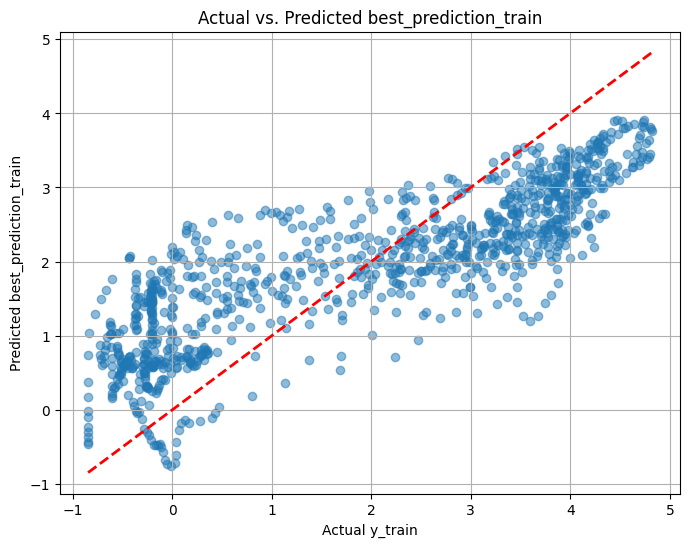

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(y_train, best_ridge_prediction_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2) # Add a line for perfect prediction
plt.xlabel("Actual y_train")
plt.ylabel("Predicted best_prediction_train")
plt.title("Actual vs. Predicted best_prediction_train")
plt.grid(True)
plt.show()

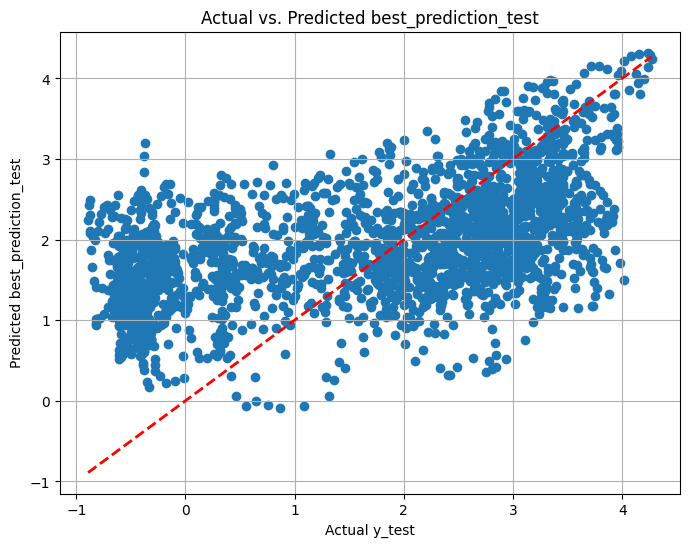

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, best_ridge_prediction_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a line for perfect prediction
plt.xlabel("Actual y_test")
plt.ylabel("Predicted best_prediction_test")
plt.title("Actual vs. Predicted best_prediction_test")
plt.grid(True)
plt.show()

Here, the training performance is worse than Least Squares, but the testing performance is slightly better. However, in both cases, we observe a higher bias for Y close to zero or a large value. This bias is larger on the training set compared to least squares, but smaller on the testing set. This means that we are improving generalization so that our model doesn't memorize the training data.

Plotting Predictions

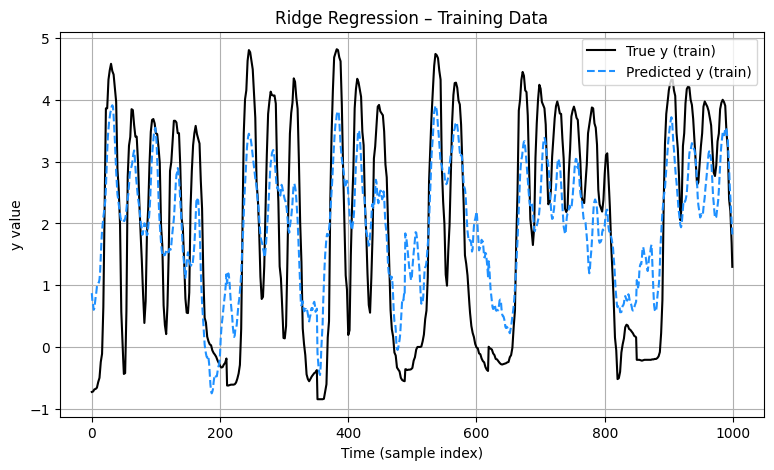

In [33]:
# --- Plot for Training Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='True y (train)', color='black')
plt.plot(best_ridge_prediction_train, label='Predicted y (train)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Ridge Regression – Training Data')
plt.legend()
plt.grid(True)

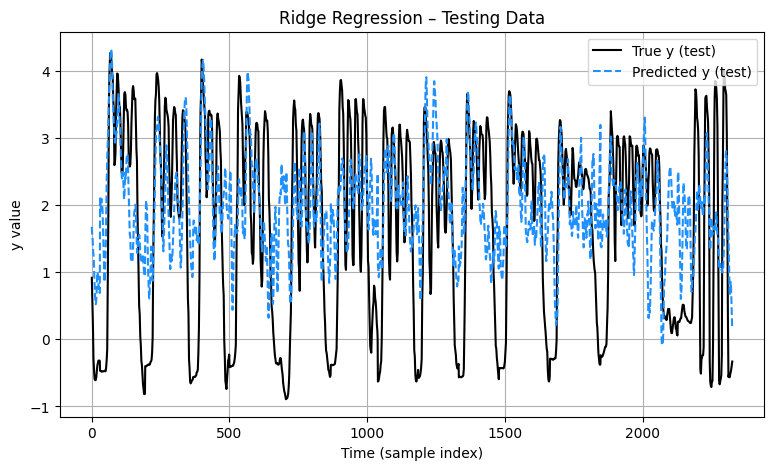

In [28]:
# --- Plot for Testing Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True y (test)', color='black')
plt.plot(best_ridge_prediction_test, label='Predicted y (test)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Ridge Regression – Testing Data')
plt.legend()
plt.grid(True)

Somehow, Ridge regression recovers some of the trend, but our predictions are not perfect. The training predictions look better than the testing predictions, which is somehow expected. However, maybe trying feature selection with Lasso or nonlinear models can recover a better approximation.

We can clearly realize that Ridge's predictions don't capture the low extreme values and sometimes it predicts a high positive value instead of a high negative one.

Performance Evaluation

In [29]:
print('MSE on the training data:', mean_squared_error(y_train, best_ridge_prediction_train))
print('R2 on the training data:', r2_score(y_train, best_ridge_prediction_train))

MSE on the training data: 1.1719430382009632
R2 on the training data: 0.6268406996047915


In [30]:
print('MSE on the test data:', mean_squared_error(y_test, best_ridge_prediction_test))
print('R2 on the test data:', r2_score(y_test, best_ridge_prediction_test))

MSE on the test data: 1.6239059826952074
R2 on the test data: 0.23848766129037868


Compared to the Least Square Method:
- The training performances are worse, which is expected due to the regularization parameter shrinking weights to generalize better. R2 = 0.63 means we can explain around 63% of total variations in our predictions.
- The testing performance is much better because we were able to generalize better than before but it's still bad. R2 = 0.24 means we can only explain 24% of the total variation. This means we are still not doing well, and the difference is evaluation metrics between train and test indicates that we're still suffering from overfitting.

Perhaps we should try more complex models. (Check below).

Coefficients LS vs Ridge

I will rerun the models to store their coefficients efficiently.

In [31]:
lr= LinearRegression()
lr.fit(x_train, y_train)

w_lr = lr.coef_

ridge = Ridge(alpha=best_lambda_ridge)
ridge.fit(x_train, y_train)

w_ridge = ridge.coef_

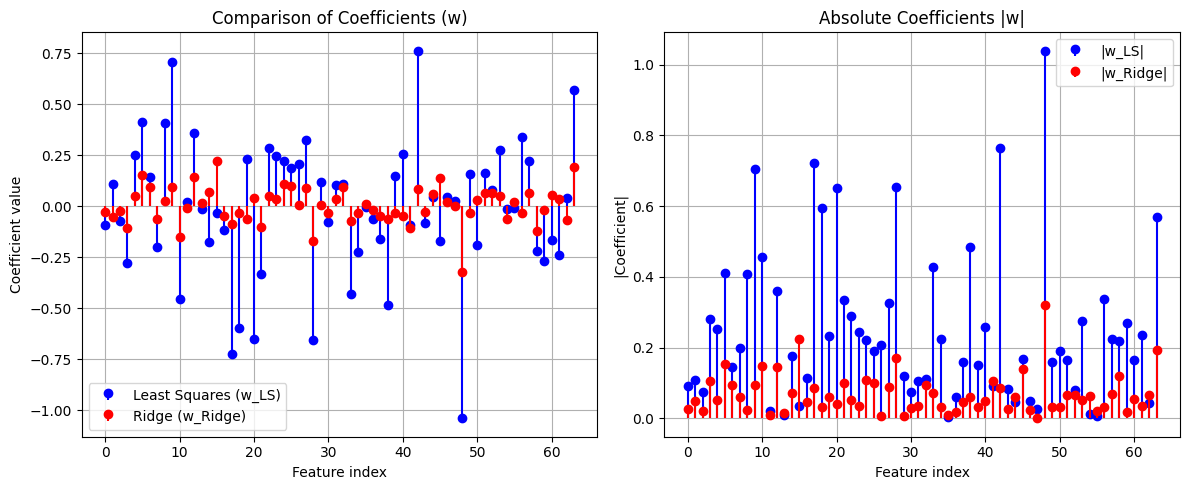

In [32]:
w_lr = np.ravel(w_lr)
w_ridge = np.ravel(w_ridge)

plt.figure(figsize=(12, 5))

# --- (1) Coefficients values ---
plt.subplot(1, 2, 1)
plt.stem(w_lr, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(w_ridge, linefmt='r-', markerfmt='ro', basefmt=' ')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.title('Comparison of Coefficients (w)')
plt.legend(['Least Squares (w_LS)', 'Ridge (w_Ridge)'])
plt.grid(True)

# --- (2) Absolute coefficient magnitudes ---
plt.subplot(1, 2, 2)
plt.stem(np.abs(w_lr), linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(np.abs(w_ridge), linefmt='r-', markerfmt='ro', basefmt=' ')
plt.xlabel('Feature index')
plt.ylabel('|Coefficient|')
plt.title('Absolute Coefficients |w|')
plt.legend(['|w_LS|', '|w_Ridge|'])
plt.grid(True)

plt.tight_layout()
plt.show()

We can see that the ridge coefficients' absolute values are much smaller than the least squares' coefficients. The reason is that the regularization term shrinked the ridge weights a lot.

Ridge and LS don't show the same important variables. In fact, LS shows many important variables with high-valued weights while ridge shows many of them near zero. I can see one feature (the largest one in both) that indicates that both models identified it as the most important. However, its magnitude with ridge is much lower than with LS.

Perhaps, we should try to perform feature selection to see if we can reduce the number of features and keep the most important ones.

5) Variable Selection with the Lasso

In [34]:
from sklearn.linear_model import Lasso

In [41]:
lasso = Lasso()

lasso.fit(x_train, y_train)

Lasso()

In [42]:
predicted_train_lasso= lasso.predict(x_train)
predicted_test_lasso = lasso.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, predicted_train_lasso))
print('R2 on the training data:', r2_score(y_train, predicted_train_lasso))

print('MSE on the test data:', mean_squared_error(y_test, predicted_test_lasso))
print('R2 on the test data:', r2_score(y_test, predicted_test_lasso))

MSE on the training data: 3.1405971577280063
R2 on the training data: 0.0
MSE on the test data: 2.190675841640482
R2 on the test data: -0.02729265197579034


In [43]:
lambdas = np.logspace(-3, 5, 100)

MSE_train = []
MSE_test = []

# Loop over λ values
for i, reg in enumerate(lambdas):
    lasso = Lasso(alpha=reg, max_iter=10000)
    lasso.fit(x_train, y_train)

    # Predictions
    y_pred_train = lasso.predict(x_train)
    y_pred_test = lasso.predict(x_test)

    # Compute MSEs
    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred_test))

# Convert lists to numpy arrays for easier manipulation
MSE_train = np.array(MSE_train)
MSE_test = np.array(MSE_test)

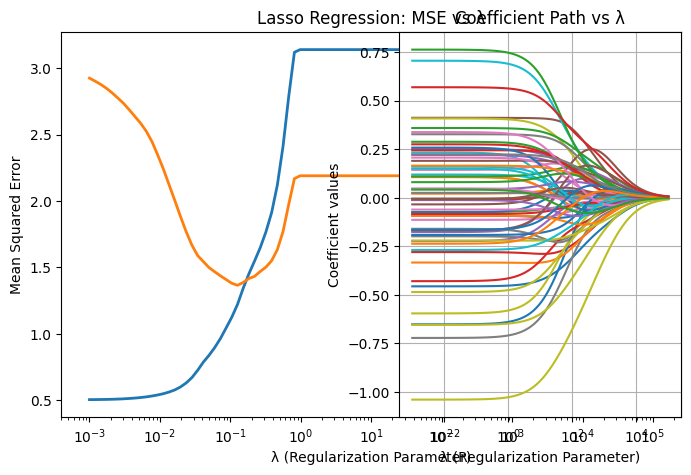

In [44]:
plt.figure(figsize=(8,5))
plt.semilogx(lambdas, MSE_train, label='Train MSE', linewidth=2)
plt.semilogx(lambdas, MSE_test, label='Test MSE', linewidth=2)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Regression: MSE vs λ')
plt.legend()

# Coefficient evolution
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, coefs)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Coefficient values')
plt.title('Coefficient Path vs λ')

plt.grid(True)
plt.show()

In [45]:
best_idx_lasso = np.argmin(MSE_test)
best_lambda_lasso = lambdas[best_idx_lasso]

print(f"Best λ = {best_lambda_lasso:.4f}")

Best λ = 0.1262


In [39]:
best_lasso = Lasso(alpha=best_lambda_lasso)
best_lasso.fit(x_train, y_train)

best_lasso_predicted_train = best_lasso.predict(x_train)
best_lasso_predicted_test = best_lasso.predict(x_test)

In [40]:
print('MSE on the training data:', mean_squared_error(y_train, best_lasso_predicted_train))
print('R2 on the training data:', r2_score(y_train, best_lasso_predicted_train))

print('MSE on the test data:', mean_squared_error(y_test, best_lasso_predicted_test))
print('R2 on the test data:', r2_score(y_test, best_lasso_predicted_test))

MSE on the training data: 1.2215631527944377
R2 on the training data: 0.6110411200657935
MSE on the test data: 1.3659542352560023
R2 on the test data: 0.359451214944292


We are still suffering from overfitting, as the training results are much better than the testing results. However, the test results are much better than the ones obtained with Least Squares and Ridge (R2 = 0.36 VS 0.24 and -0.42 for Ridge and Lasso respectively). This explains that Lasso was able to generalize in a better way than Least Squares or Ridge, even if it is not a perfect model. Maybe, we should try nonlinear models to see whether they would catch more complex features and have better performance results on the test set, or if they will instead overfit the training data and perform bad on the test set (check next part).

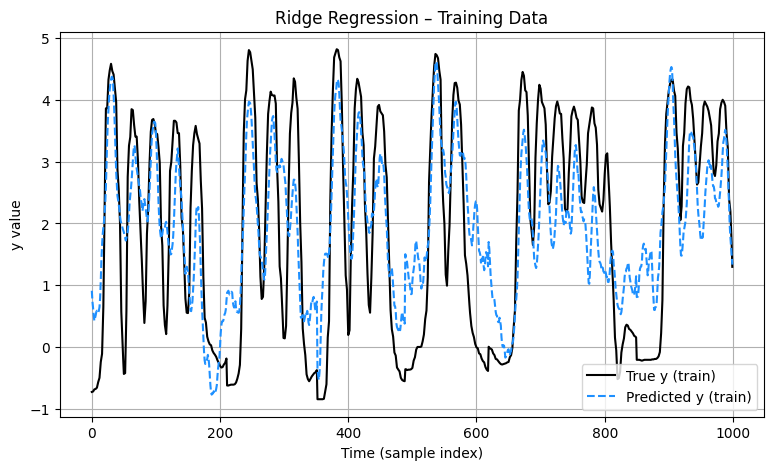

In [41]:
# --- Plot for Training Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='True y (train)', color='black')
plt.plot(best_lasso_predicted_train, label='Predicted y (train)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Ridge Regression – Training Data')
plt.legend()
plt.grid(True)

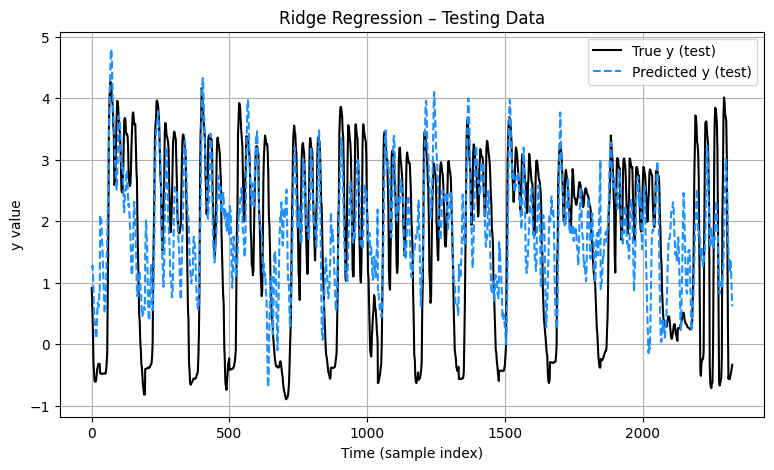

In [42]:
# --- Plot for Testing Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True y (test)', color='black')
plt.plot(best_lasso_predicted_test, label='Predicted y (test)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Ridge Regression – Testing Data')
plt.legend()
plt.grid(True)

Predicted Values on the Training Set:
It is better than the test set which is expected as the model's parameters were learned with this dataset. It performed similarly to Ridge.

Predicted Values on the Test set:
Here it is much better than Ridge. In fact, the model was able to catch the highly negative values (the extreme ones) while Ridge was not able. This is due to Lasso generalizing better than Ridge. However, we can't say that our predictions are perfect. It is also worth mentioning that the data is somehow noisy, making it more difficult to catch its trend.

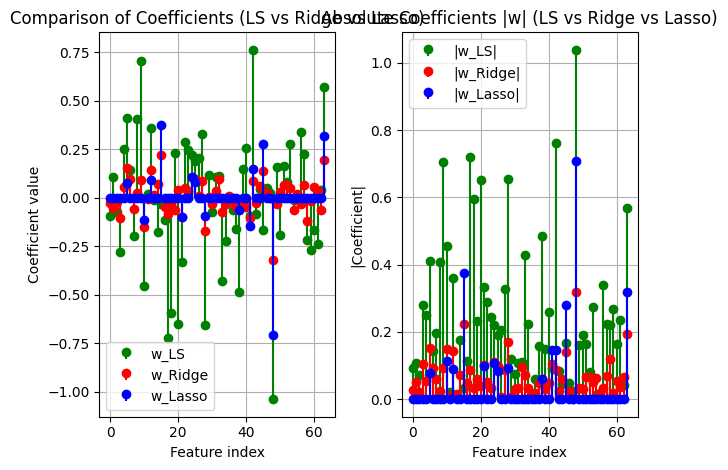

In [45]:
# --- (1) Raw Coefficient Values ---
w_lasso = best_lasso.coef_

plt.subplot(1, 2, 1)
plt.stem(w_lr, linefmt='g-', markerfmt='go', basefmt=' ')       # LS in green
plt.stem(w_ridge, linefmt='r-', markerfmt='ro', basefmt=' ') # Ridge in red
plt.stem(w_lasso, linefmt='b-', markerfmt='bo', basefmt=' ') # Lasso in blue
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.title('Comparison of Coefficients (LS vs Ridge vs Lasso)')
plt.legend(['w_LS', 'w_Ridge', 'w_Lasso'])
plt.grid(True)

# --- (2) Absolute Coefficient Magnitudes ---
plt.subplot(1, 2, 2)
plt.stem(np.abs(w_lr), linefmt='g-', markerfmt='go', basefmt=' ')
plt.stem(np.abs(w_ridge), linefmt='r-', markerfmt='ro', basefmt=' ')
plt.stem(np.abs(w_lasso), linefmt='b-', markerfmt='bo', basefmt=' ')
plt.xlabel('Feature index')
plt.ylabel('|Coefficient|')
plt.title('Absolute Coefficients |w| (LS vs Ridge vs Lasso)')
plt.legend(['|w_LS|', '|w_Ridge|', '|w_Lasso|'])
plt.grid(True)

plt.tight_layout()
plt.show()

We observe that the LS coefficients (green) have large variability, with both high positive and negative values. This reflects overfitting and instability due to the absence of regularization, especially in the presence of correlated features (electrodes 45 and 48 as shown at the begininng for example).

The Ridge coefficients (red) are more regularized — they are smaller in magnitude and less dispersed. Ridge keeps all variables but shrinks their influence, reducing model variance while maintaining smoothness.

The Lasso coefficients (blue) are the most constrained: many are exactly zero, showing sparsity. This means Lasso performs feature selection, keeping only the most influential electrodes and discarding redundant ones.

Some of the most important variables (with the largest absolute values) are generally consistent across models — Ridge and Lasso identify similar key electrodes as LS but with reduced magnitude. Lasso kept some coefficients with almost the same magnitude as Least Squares did, but removed many variables by putting their coefficients to zero. Ridge reduced the overall average magnitude for all weights, but didn't promote sparsity.

All three capture the same overall structure of the relationship between inputs and output, differing mainly in how strongly they penalize coefficient size.

Overall, Ridge improves stability compared to LS, while Lasso enhances interpretability by identifying the most relevant electrodes for predicting finger flexion.

In [46]:
# Ensure coefficients are a 1D array
w_lasso = np.ravel(w_lasso)

# Get indices of the 2 largest absolute coefficients
top2_idx = np.argsort(np.abs(w_lasso))[-2:][::-1]  # sorted descending

print("Indices of 2 most important features:", top2_idx)
print("Corresponding coefficients:", w_lasso[top2_idx])
print("Absolute values:", np.abs(w_lasso[top2_idx]))

Indices of 2 most important features: [48 15]
Corresponding coefficients: [-0.70862161  0.37611771]
Absolute values: [0.70862161 0.37611771]


These 2 features represent the ones having the most impact in predicting the target variable. They have in fact the highest absolute coefficients' values.

In [ ]:
w_lasso = np.ravel(w_lasso)

n_features= len(w_lasso)

n_selected = np.sum(w_lasso != 0)

print('Initial Number of Features:', n_features)
print('Number of Features selected by Lasso:', n_selected)

Initial Number of Features: 64
Number of Features selected by Lasso: 14


We can observe a reduction of 50 features thanks to Lasso Regression. Perhaps for the future we should focus only on the electrodes selected by this model.

However, as mentioned before, all the Linear Models we tested are not performing very well especially on the test data. This is due to several factors:
- The training set isn't very large.
- The observations are somehow noisy (as explained at the beginning).
- Some features are correlated (but we solved this with Lasso).
- The relationships between the variables might be non-linear.

 We will try nonlinear methods to see if they'll perform better. We should worry however about overfitting due to the small training set and the noisy observations. Check the next part below.

6) Nonlinear Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

Fitting the 3 nonlinear models

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

rf_prediction_train = rf.predict(x_train)
rf_prediction_test = rf.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, rf_prediction_train))
print('R2 on the training data:', r2_score(y_train, rf_prediction_train))

print('MSE on the test data:', mean_squared_error(y_test, rf_prediction_test))
print('R2 on the test data:', r2_score(y_test, rf_prediction_test))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE on the training data: 0.02232492543528405
R2 on the training data: 0.9928915030123014
MSE on the test data: 1.6256841820937247
R2 on the test data: 0.23765379479990023


In [ ]:
svr = SVR()
svr.fit(x_train, y_train)

svr_prediction_train = svr.predict(x_train)
svr_prediction_test = svr.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, svr_prediction_train))
print('R2 on the training data:', r2_score(y_train, svr_prediction_train))

print('MSE on the test data:', mean_squared_error(y_test, svr_prediction_test))
print('R2 on the test data:', r2_score(y_test, svr_prediction_test))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on the training data: 0.024085982516610357
R2 on the training data: 0.9923307634481734
MSE on the test data: 1.515182870123942
R2 on the test data: 0.28947213490412815


In [ ]:
mlp = MLPRegressor()
mlp.fit(x_train, y_train)

mlp_prediction_train = mlp.predict(x_train)
mlp_prediction_test = mlp.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, mlp_prediction_train))
print('R2 on the training data:', r2_score(y_train, mlp_prediction_train))

print('MSE on the test data:', mean_squared_error(y_test, mlp_prediction_test))
print('R2 on the test data:', r2_score(y_test, mlp_prediction_test))

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on the training data: 0.0065819063064069365
R2 on the training data: 0.9979042500595114
MSE on the test data: 2.2620075369937704
R2 on the test data: -0.06074284350870762


The three models are performing extremly well on the training data (0.99 R2) but very bad on the test data. This means we are suffering from overfitting and we should optimize our hyperparameters. I will conduct a grid search for each model

Hyperparameter Tuning

In [ ]:
param_grid_rf = {
    'n_estimators': [5, 10, 25, 50], ## not very high to see if i can overcome overfitting
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
}

param_grid_svr = {
    'C': [0.001, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(15,), (50,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.01, 0.1]
}

In [ ]:
## Grid Search for rf
from sklearn.model_selection import GridSearchCV


grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(x_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print("Best Parameters for Random Forest:", best_params_rf)

best_prediction_train_rf = best_model_rf.predict(x_train)
best_prediction_test_rf = best_model_rf.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, best_prediction_train_rf))
print('R2 on the training data:', r2_score(y_train, best_prediction_train_rf))

print('MSE on the test data:', mean_squared_error(y_test, best_prediction_test_rf))
print('R2 on the test data:', r2_score(y_test, best_prediction_test_rf))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Parameters for Random Forest: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
MSE on the training data: 0.0427889633397486
R2 on the training data: 0.9863755326803189
MSE on the test data: 1.6888137641361252
R2 on the test data: 0.2080498915104495


In [ ]:
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(x_train, y_train)

best_params_svr = grid_search_svr.best_params_
best_model_svr = grid_search_svr.best_estimator_

print("Best Parameters for SVR:", best_params_svr)

best_prediction_train_svr = best_model_svr.predict(x_train)
best_prediction_test_svr = best_model_svr.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, best_prediction_train_svr))
print('R2 on the training data:', r2_score(y_train, best_prediction_train_svr))

print('MSE on the test data:', mean_squared_error(y_test, best_prediction_test_svr))
print('R2 on the test data:', r2_score(y_test, best_prediction_test_svr))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters for SVR: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
MSE on the training data: 0.00182560948444096
R2 on the training data: 0.9994187062546532
MSE on the test data: 1.5320010113420917
R2 on the test data: 0.2815854578500012


In [ ]:
grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(x_train, y_train)

best_params_mlp = grid_search_mlp.best_params_
best_model_mlp = grid_search_mlp.best_estimator_

print("Best Parameters for MLP:", best_params_mlp)

best_prediction_train_mlp = best_model_mlp.predict(x_train)
best_prediction_test_mlp = best_model_mlp.predict(x_test)

print('MSE on the training data:', mean_squared_error(y_train, best_prediction_train_mlp))
print('R2 on the training data:', r2_score(y_train, best_prediction_train_mlp))

print('MSE on the test data:', mean_squared_error(y_test, best_prediction_test_mlp))
print('R2 on the test data:', r2_score(y_test, best_prediction_test_mlp))

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

Best Parameters for MLP: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (50, 50)}
MSE on the training data: 0.006074797902240724
R2 on the training data: 0.998065718843535
MSE on the test data: 2.277849630593819
R2 on the test data: -0.06817181407472983


True vs Predicted Values

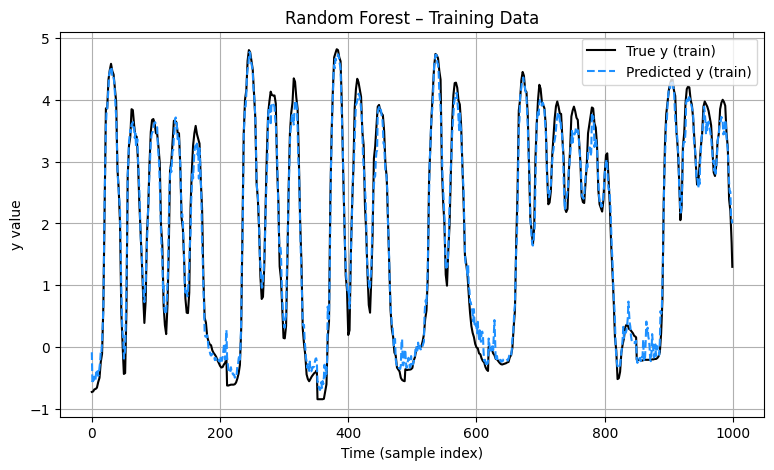

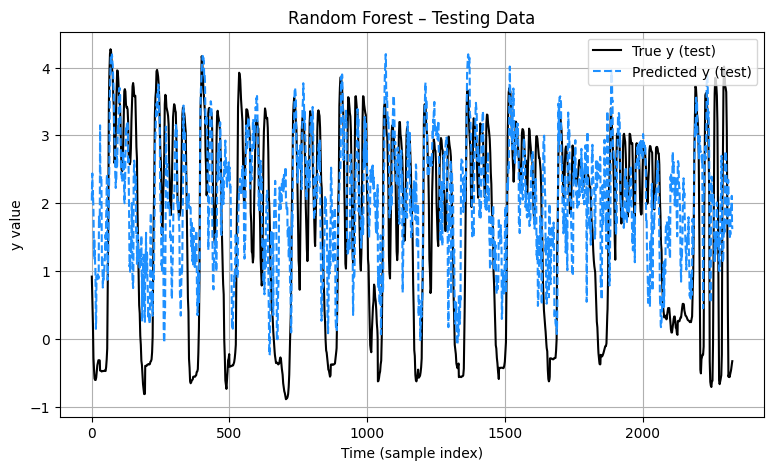

In [ ]:
# Random Forest

# --- Plot for Training Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='True y (train)', color='black')
plt.plot(best_prediction_train_rf, label='Predicted y (train)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Random Forest – Training Data')
plt.legend()
plt.grid(True)

# --- Plot for Testing Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True y (test)', color='black')
plt.plot(best_prediction_test_rf, label='Predicted y (test)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('Random Forest – Testing Data')
plt.legend()
plt.grid(True)

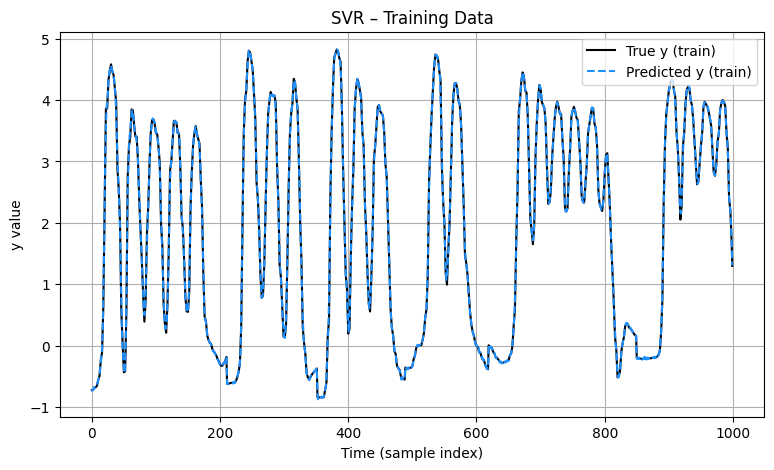

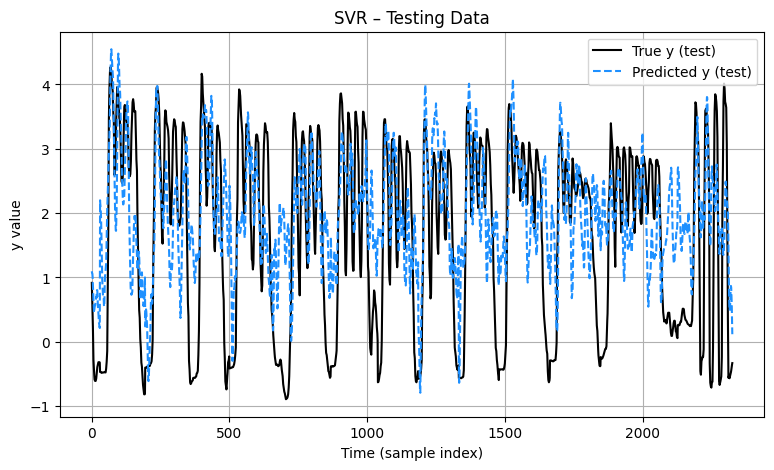

In [ ]:
# --- Plot for Training Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='True y (train)', color='black')
plt.plot(best_prediction_train_svr, label='Predicted y (train)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('SVR – Training Data')
plt.legend()
plt.grid(True)

# --- Plot for Testing Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True y (test)', color='black')
plt.plot(best_prediction_test_svr, label='Predicted y (test)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('SVR – Testing Data')
plt.legend()
plt.grid(True)

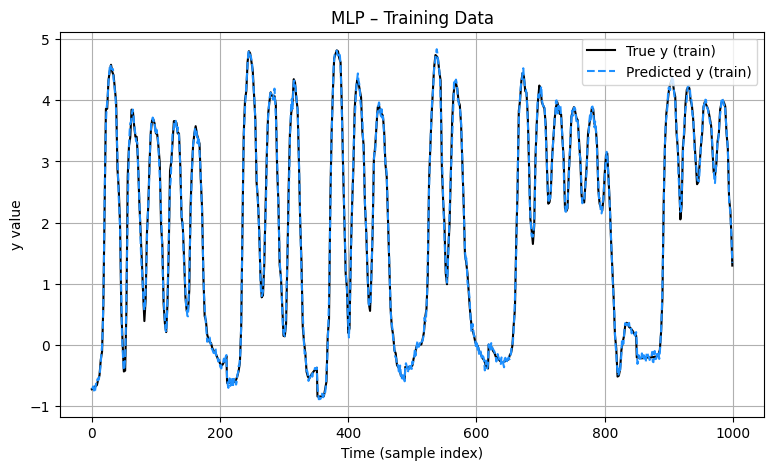

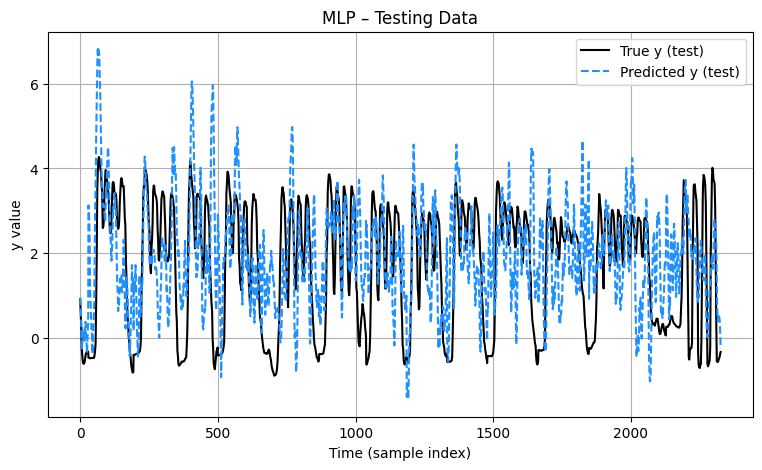

In [ ]:
# --- Plot for Training Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='True y (train)', color='black')
plt.plot(best_prediction_train_mlp, label='Predicted y (train)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('MLP – Training Data')
plt.legend()
plt.grid(True)

# --- Plot for Testing Data ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True y (test)', color='black')
plt.plot(best_prediction_test_mlp, label='Predicted y (test)', color='dodgerblue', linestyle='--')
plt.xlabel('Time (sample index)')
plt.ylabel('y value')
plt.title('MLP – Testing Data')
plt.legend()
plt.grid(True)

First, we can say that all 3 nonlinear models suffer a lot from overfitting: they all performed very well on the training data, with a R2 = 0.99 and predicted values being exactly similar to the actual values. However, they all performed much worse on the test set.

- Random Forest and SVR: On the test set, we can say that Random Forest is as good as Ridge because of the close evaluation metrics, while SVR is a bit better. That's mainly due to Random Forest being much more complex than SVR, which is why I didn't include more complex hyperparameters. However, both models didn't perform as good as Lasso. The reason why those nonlinear models performed that good on the training set is because their highly complex structures (many weak models for Random Forest and Kernel methods in SVR) catched and learned the noisy observations and memorized them, as the training set is small. But when it came to testing, both models performed worse than Lasso, which is much simpler. This shows  us the tradeoff between model complexity and generalization bias-variance tradeoff. If we want to compare the plots of RF and SVR, we can see that SVR generalized better and predicted values that are less noisy than Random Forest.

- MLP: The model performed extremely well on the training set but extremly bad on the test set (R2 almost negative). The reason is that this model is very complex, with hidden layers, nonlinearities in activation functions and large number of neurons. This has learned and memorized the noisy and small observations from the training set, but couldn't handle the test set. The high variance can be seen in the plot between true vs predicted values on the test set: it includes a lot of jumps and noisy predictions because of the way it learned from the training data.

7- Final Comparison of the Performances

- DataFrame Comparison Table

In [ ]:
# === LEAST SQUARE ===
mse_train_ls = mean_squared_error(y_train, predict_train_ls)
mse_test_ls  = mean_squared_error(y_test,  predict_test_ls)
r2_train_ls  = r2_score(y_train, predict_train_ls)
r2_test_ls   = r2_score(y_test,  predict_test_ls)

# === RIDGE ===
mse_train_ridge = mean_squared_error(y_train, best_ridge_prediction_train)
mse_test_ridge  = mean_squared_error(y_test,  best_ridge_prediction_test)
r2_train_ridge  = r2_score(y_train, best_ridge_prediction_train)
r2_test_ridge   = r2_score(y_test,  best_ridge_prediction_test)

# === LASSO ===
mse_train_lasso = mean_squared_error(y_train, best_lasso_predicted_train)
mse_test_lasso  = mean_squared_error(y_test,  best_lasso_predicted_test)
r2_train_lasso  = r2_score(y_train, best_lasso_predicted_train)
r2_test_lasso   = r2_score(y_test,  best_lasso_predicted_test)

# === RANDOM FOREST ===
mse_train_rf = mean_squared_error(y_train, best_prediction_train_rf)
mse_test_rf  = mean_squared_error(y_test,  best_prediction_test_rf)
r2_train_rf  = r2_score(y_train, best_prediction_train_rf)
r2_test_rf   = r2_score(y_test,  best_prediction_test_rf)

# === SVR ===
mse_train_svr = mean_squared_error(y_train, best_prediction_train_svr)
mse_test_svr  = mean_squared_error(y_test,  best_prediction_test_svr)
r2_train_svr  = r2_score(y_train, best_prediction_train_svr)
r2_test_svr   = r2_score(y_test,  best_prediction_test_svr)

# === MLP ===
mse_train_mlp = mean_squared_error(y_train, best_prediction_train_mlp)
mse_test_mlp  = mean_squared_error(y_test,  best_prediction_test_mlp)
r2_train_mlp  = r2_score(y_train, best_prediction_train_mlp)
r2_test_mlp   = r2_score(y_test,  best_prediction_test_mlp)


In [ ]:
## DataFrame with the results
# Build a comparison DataFrame
results = pd.DataFrame({
    'MSE train': [mse_train_ls, mse_train_ridge, mse_train_lasso, mse_train_rf, mse_train_svr, mse_train_mlp],
    'MSE test':  [mse_test_ls, mse_test_ridge, mse_test_lasso, mse_test_rf, mse_test_svr, mse_test_mlp],
    'R2 train':  [r2_train_ls, r2_train_ridge, r2_train_lasso, r2_train_rf, r2_train_svr, r2_train_mlp],
    'R2 test':   [r2_test_ls, r2_test_ridge, r2_test_lasso, r2_test_rf, r2_test_svr, r2_test_mlp]
}, index=['Least Squares', 'Ridge', 'Lasso', 'Random Forest', 'SVR', 'MLP'])

print(results)


               MSE train  MSE test  R2 train   R2 test
Least Squares   0.504065  3.045537  0.839500 -0.428170
Ridge           1.171943  1.623906  0.626841  0.238488
Lasso           1.221563  1.365954  0.611041  0.359451
Random Forest   0.042789  1.688814  0.986376  0.208050
SVR             0.001826  1.532001  0.999419  0.281585
MLP             0.006075  2.277850  0.998066 -0.068172


We can clearly see that complex models suffer a lot from overfitting, as they performed extremly well on the training data but worse on testing data.
For linear regression, we can also see overfitting mainly because we didn't adopt regularization techniques. Finally, Ridge generalized better because it shrinked coefficients, but Lasso is the one that performed the best: it set many weights to zero (least square had assigned them magnitude) but kept the most important features. It is the one that generalizes the best between the models (difference between training and testing metrics).

Now we can compare SVR and Random Forest with Ridge:
- They tested almost similarly on the test data (0.28, 0.21 and 0.23 for R2). However, Ridge has a better generalization because it didn't perform extremly well on the training set (0.62 vs 0.99 for R2 between the 3 models).
- This means that Ridge is slighty better in terms of testing performance, but is significantly better in terms of generalization.

MLP is the model that performed the best on the training set but one of the worst on the testing set. This means that we definitely don't need such complex models for this dataset and also we can't train a neural network on a small amount of data.

To conclude, Lasso Regression corresponds to the best model in terms of complexity, performance on the test set and generalization. However, the model is still not perfect as it can only explain 36% of our variations.


- Most interpretable Models

Linear models are the most interpretable ones. We can easily justify the relation between every electrode with the position thanks to the weight coefficients. Additionally, with the Lasso Regression Model, we can identify the electrodes that we should take into consideration and the ones we shouldn't care about thanks to its sparse solution: The weights with coefficient = 0 can be neglected for future experiments.

- Best model from a medical/ practical perspective

The Lasso regression model is the best one from a medical/ practical perpective. This is due to several reasons:

1- It is the one that generalized the best among the other models, and had the best results on the test dataset. However, it doesn't have excellent results (R2 = 0.36 is still low).

2- From a medical perspective, it might be better to have an interpretable model where we can understand why it performed that way than a complex, black-box model.

- Do we need nonlinearity in this application?

Based on our results, it is better to stick to linear models as they performed better or similar to the nonlinear ones. The fact that we don't have a large number of training samples suggests that nonlinear or complex models (ensemble or MLP) will overfit the training data and perform bad on the test data. If we can have access to a larger training set, then we should test the nonlinear and linear models and assess the tradeoff between: model interpretability, generalization and time complexity,

- Evaluation on the test data

Instead of validating our model on the test data, I would use a validation set. This means that our training data will be splitted into training and validation (and sometimes we can create multiple sets but we need to be careful when dealing with time series data) where we evaluate each training epoch on the validation set. This would be better if we were to provide our model for a client, as we would at the end have the best model before going to the testing phase.

## Personal Discussion

- I really liked the fact that we had to test many linear models and compare them, to see how the Lasso will set many weights to zero. It was also interesting to see how complex models suffered from overfitting, and discuss the tradeoff between model interpretability, complexity and generalization.

- What I didn't find logic was the number of training samples that was less than the number of testing samples.

- It wasn't logic to choose the best lambda for the test set as we should do it on a validation set, but that was discussed in part 7. Personally, I used GridSearchCV for the complex models to handle this issue.

- In the optimization for data science course, we studied how to train a Lasso with Proximal Gradient Descent. It was interesting to use it here in practice while seeing in the other course how it works 'behind the scenes'.

- I liked the relation to professional use case of models, where we could have interpreted the tradeoff between model interpretability, complexity and evaluation metrics.